In [2]:
!pwd

/mydir


In [2]:
import cv2

In [3]:
print(cv2.__version__)

4.5.5


In [6]:
!wget -N -q  https://raw.githubusercontent.com/haofeixu/flow1d/main/demo/dogs-jump/00033.jpg
!wget -N -q  https://raw.githubusercontent.com/haofeixu/flow1d/main/demo/dogs-jump/00034.jpg
!wget -N -q  https://raw.githubusercontent.com/haofeixu/flow1d/main/demo/dogs-jump/00035.jpg
!wget -N -q  https://raw.githubusercontent.com/haofeixu/flow1d/main/demo/dogs-jump/00036.jpg
    
    

In [46]:
import numpy as np 
import cv2
import time 
import matplotlib.pyplot as plt 

print("opencv ver : ", cv2.__version__)

tic=time.time()
#frame1 = (cv2.imread('/mydir/00033.jpg', cv2.IMREAD_GRAYSCALE))
#frame2 = (cv2.imread('/mydir/00034.jpg', cv2.IMREAD_GRAYSCALE))

frame1 = (cv2.imread('/mydir/00033.jpg' ) )
frame2 = (cv2.imread('/mydir/00034.jpg' ) )
          
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)  
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)      

toc = time.time()


opencv ver :  4.5.5


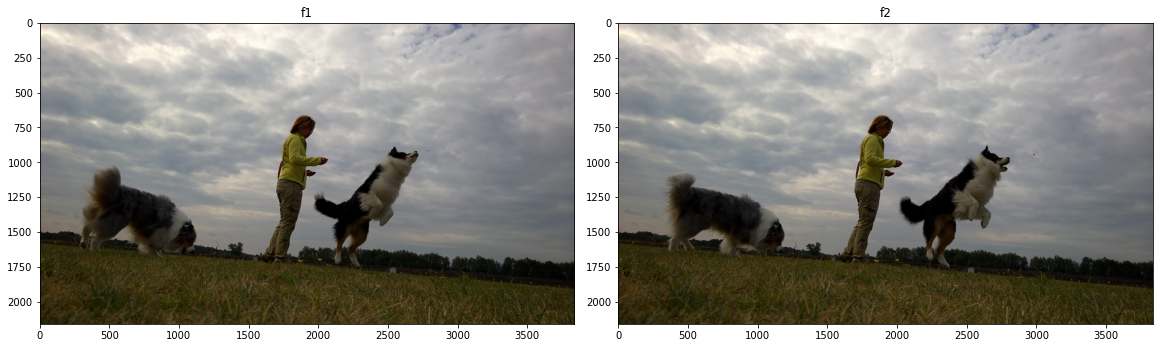

In [42]:
fig_size_default = 8
num_plot = 2
fig, axs = plt.subplots(1, num_plot, figsize= (fig_size_default*num_plot, fig_size_default ) , constrained_layout=True) 
axs[0].imshow(frame1 ,  interpolation=None,    origin='upper', cmap='gray'  )
axs[0].set_title('f1')
axs[1].imshow(frame2,  interpolation=None,    origin='upper' , cmap='gray'  )
axs[1].set_title('f2')

plt.show()


In [3]:
def flow_arrow(flow, step=8, size=4):
    step = step
    ratio =  flow.shape[1] / flow.shape[0] 
    plt.figure(figsize=( int(size * ratio) ,size))
    plt.title('Optical Flow vector')
    Q= plt.quiver( np.arange(0, flow.shape[1] -1, step), 
               np.arange(flow.shape[0]-1 , -1, -step),             
               flow[::step, ::step, 0], 
               flow[::step, ::step, 1], units='x', pivot='mid', width=1,  scale=0.4, color='red')
    plt.axis('off')
    plt.show()


In [4]:
#@title flow color
def make_colorwheel():
    import numpy as np     
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY)
    col = col + RY
    # YG
    colorwheel[col:col + YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG)
    colorwheel[col:col + YG, 1] = 255
    col = col + YG
    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC, 2] = np.floor(255 * np.arange(0, GC) / GC)
    col = col + GC
    # CB
    colorwheel[col:col + CB, 1] = 255 - np.floor(255 * np.arange(CB) / CB)
    colorwheel[col:col + CB, 2] = 255
    col = col + CB
    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM, 0] = np.floor(255 * np.arange(0, BM) / BM)
    col = col + BM
    # MR
    colorwheel[col:col + MR, 2] = 255 - np.floor(255 * np.arange(MR) / MR)
    colorwheel[col:col + MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''
    import numpy as np  
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) # + 1
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 1
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:, i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1 - f) * col0 + f * col1

        idx = (rad <= 1)
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        col[~idx] = col[~idx] * 0.75  # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2 - i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''
    import numpy as np  
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:, :, 0]
    v = flow_uv[:, :, 1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)    

In [45]:
import numpy as np 
import cv2
import time 

print("opencv ver : ", cv2.__version__)

tic=time.time()
frame1 = (cv2.imread('/mydir/00033.jpg' ) )
frame2 = (cv2.imread('/mydir/00034.jpg' ) )
          
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB) 
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)   

toc = time.time()


print("init nvhwof2, slow, 2 2 ")
nvof = cv2.cuda_NvidiaOpticalFlow_2_0.create( (frame1.shape[1], frame1.shape[0] ) , \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_PERF_LEVEL_SLOW, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_OUTPUT_VECTOR_GRID_SIZE_1, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_HINT_VECTOR_GRID_SIZE_1,  \
    False, False, False,  \
    0, )

print(nvof)
print("gray scale input")
for i in range(1,2,1):
    tic = time.time()
    flow_hw2 = nvof.calc(frame1, frame2, None)
    toc = time.time()
    dur = toc - tic 
    print("cal nvhwof2 ", frame1.shape, len(flow_hw2), flow_hw2[0].shape, dur)
    
tic = time.time()
cv2.writeOpticalFlow('OpticalFlow_org.flo', flow_hw2[0])
toc = time.time()
dur = toc - tic
print("save flo", dur )

print(flow_hw2[0].shape)

print(flow_hw2[0].shape)
print("stat : ", np.max(flow_hw2[0] )    , np.min(flow_hw2[0] ) , np.mean(flow_hw2[0]))


plt.imshow(flow_hw2[0][:,:,0])
plt.show()

plt.imshow(flow_hw2[0][:,:,1])
plt.show()
flow_img = flow_to_color(flow_hw2[0])
plt.imshow(flow_img)

nvof.collectGarbage()




opencv ver :  4.5.5
init nvhwof2, slow, 2 2 
<cuda_NvidiaOpticalFlow_2_0 0x7fc8a0dd16d0>
gray scale input


error: OpenCV(4.5.5) /opt/opencv-python/opencv/modules/core/src/cuda/gpu_mat.cu:236: error: (-217:Gpu API call) invalid pitch argument in function 'upload'


 ### nvhwof2 on opencv

opencv ver :  4.5.5
init nvhwof2, slow, 2 2 
<cuda_NvidiaOpticalFlow_2_0 0x7fc9036de690>
gray scale input
cal nvhwof2  (2160, 3840) 2 (2160, 3840, 2) 0.025097370147705078
save flo 9.274482727050781e-05
(2160, 3840, 2)
(2160, 3840, 2)
stat :  11112 -3168 94.82519290123457


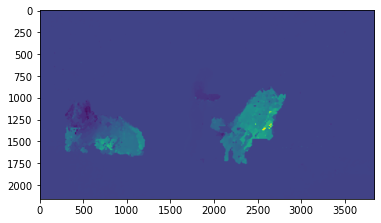

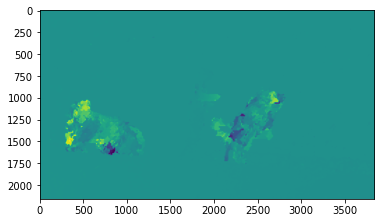

/tmp/ipykernel_403/3106288235.py:110: RuntimeWarning: invalid value encountered in sqrt
  rad = np.sqrt(np.square(u) + np.square(v))


IndexError: index -2147483648 is out of bounds for axis 0 with size 55

In [40]:
import numpy as np 
import cv2
import time 

print("opencv ver : ", cv2.__version__)

tic=time.time()
frame1 = (cv2.imread('/mydir/00033.jpg', cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread('/mydir/00034.jpg', cv2.IMREAD_GRAYSCALE))
toc = time.time()


print("init nvhwof2, slow, 2 2 ")
nvof = cv2.cuda_NvidiaOpticalFlow_2_0.create( (frame1.shape[1], frame1.shape[0] ) , \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_PERF_LEVEL_SLOW, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_OUTPUT_VECTOR_GRID_SIZE_1, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_HINT_VECTOR_GRID_SIZE_1,  \
    False, False, False,  \
    0, )

print(nvof)
print("gray scale input")
for i in range(1,2,1):
    tic = time.time()
    flow_hw2 = nvof.calc(frame1, frame2, None)
    toc = time.time()
    dur = toc - tic 
    print("cal nvhwof2 ", frame1.shape, len(flow_hw2), flow_hw2[0].shape, dur)
    
tic = time.time()
cv2.writeOpticalFlow('OpticalFlow_org.flo', flow_hw2[0])
toc = time.time()
dur = toc - tic
print("save flo", dur )

print(flow_hw2[0].shape)

print(flow_hw2[0].shape)
print("stat : ", np.max(flow_hw2[0] )    , np.min(flow_hw2[0] ) , np.mean(flow_hw2[0]))


plt.imshow(flow_hw2[0][:,:,0])
plt.show()

plt.imshow(flow_hw2[0][:,:,1])
plt.show()
flow_img = flow_to_color(flow_hw2[0])
plt.imshow(flow_img)

nvof.collectGarbage()




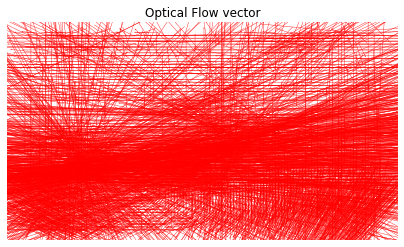

In [23]:
flow_arrow(flow_hw2[0])

In [9]:
import numpy as np 
import cv2
import time 

print("opencv ver : ", cv2.__version__)

tic=time.time()
frame1 = (cv2.imread('/mydir/00033.jpg', cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread('/mydir/00034.jpg', cv2.IMREAD_GRAYSCALE))
toc = time.time()

frame1_float = np.float32(frame1)/255
frame2_float = np.float32(frame2)/255

print("init nvhwof2, slow, 2 2 ")
nvof = cv2.cuda_NvidiaOpticalFlow_2_0.create( (frame1.shape[1], frame1.shape[0] ) , \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_PERF_LEVEL_SLOW, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_OUTPUT_VECTOR_GRID_SIZE_2, \
    cv2.cuda.NvidiaOpticalFlow_2_0_NV_OF_HINT_VECTOR_GRID_SIZE_2,  \
    False, False, False,  \
    0, )

print(nvof)
print("gray scale input")
for i in range(1,2,1):
    tic = time.time()
    flow_hw2 = nvof.calc(frame1_float, frame2_float, None)
    toc = time.time()
    dur = toc - tic 
    print("cal nvhwof2 ", frame1.shape, len(flow_hw2), flow_hw2[0].shape, dur)
    
tic = time.time()
cv2.writeOpticalFlow('OpticalFlow_org.flo', flow_hw2[0])
toc = time.time()
dur = toc - tic
print("save flo", dur )


nvof.collectGarbage()


opencv ver :  4.5.5
init nvhwof2, slow, 2 2 
<cuda_NvidiaOpticalFlow_2_0 0x7f4db020c330>
gray scale input


error: OpenCV(4.5.5) /opt/opencv-python/opencv/modules/core/src/cuda/gpu_mat.cu:236: error: (-217:Gpu API call) invalid pitch argument in function 'upload'


In [ ]:
### cuda of tvl1 algo on opencv¶

opencv ver :  4.5.5
load data 0.05405616760253906
(2160, 3840)
(2160, 3840)
malloc 0.03423500061035156
memcpy cpu to gpu for cuda of 0.028331756591796875
init cuda of
<cuda_OpticalFlowDual_TVL1 0x7fc90e346310>
float32 input
cal cuda tvl1 (2160, 3840) (2160, 3840, 2) 0.45203399658203125
(540, 960, 2)
stat :  63.272152 -49.110714 0.022928167


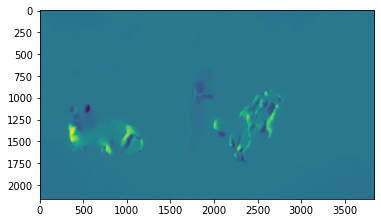

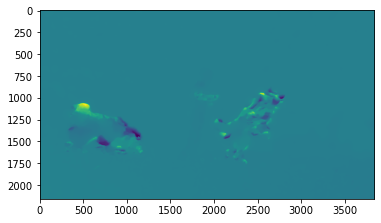

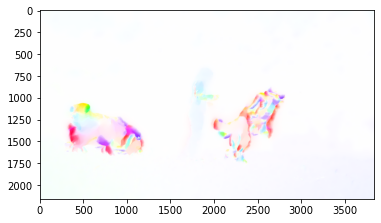

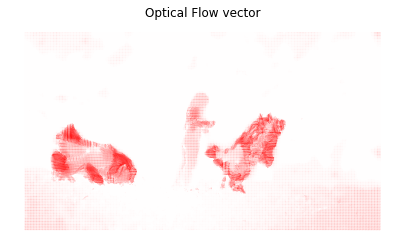

In [24]:
import numpy as np 
import cv2
import time 

print("opencv ver : ", cv2.__version__)

tic=time.time()
frame1 = (cv2.imread('/mydir/00033.jpg', cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread('/mydir/00034.jpg', cv2.IMREAD_GRAYSCALE))
toc = time.time()

dur = toc - tic
print("load data", dur)

print( frame1.shape )
print( frame2.shape )

tic = time.time()
f1_GPU = cv2.cuda_GpuMat(frame1.shape)
f2_GPU = cv2.cuda_GpuMat(frame2.shape)
toc = time.time()
dur = toc - tic 
print("malloc", dur)

tic = time.time()
f1_GPU.upload( np.float32(frame1)/255 )
f2_GPU.upload( np.float32(frame2)/255 )
toc = time.time()
dur = toc - tic 
print("memcpy cpu to gpu for cuda of", dur)

print("init cuda of")
tvl1_of = cv2.cuda_OpticalFlowDual_TVL1.create()
print(tvl1_of)

print("float32 input")
for i in range(1,2,1):
    tic = time.time()
    flow_tvl1_gpu = tvl1_of.calc(f1_GPU, f2_GPU, None)
    toc = time.time()
    flow_tvl1_cpu = flow_tvl1_gpu.download()
    dur = toc - tic 
    print("cal cuda tvl1", frame1.shape,  flow_tvl1_cpu.shape, dur)


print(flow_hw2[0].shape)
print("stat : ", np.max(flow_tvl1_cpu )    , np.min(flow_tvl1_cpu ) , np.mean(flow_tvl1_cpu))

plt.imshow(flow_tvl1_cpu[:,:,0])
plt.show()

plt.imshow(flow_tvl1_cpu[:,:,1])
plt.show()    

flow_img = flow_to_color(flow_tvl1_cpu)
plt.imshow(flow_img)

flow_arrow(flow_tvl1_cpu)

In [7]:
import numpy as np 
import cv2
import time 

print("opencv ver : ", cv2.__version__)

tic=time.time()
frame1 = (cv2.imread('/mydir/00033.jpg', cv2.IMREAD_GRAYSCALE))
frame2 = (cv2.imread('/mydir/00034.jpg', cv2.IMREAD_GRAYSCALE))
toc = time.time()

dur = toc - tic
print("load data", dur)

print( frame1.shape )
print( frame2.shape )

tic = time.time()
f1_GPU = cv2.cuda_GpuMat(frame1.shape)
f2_GPU = cv2.cuda_GpuMat(frame2.shape)
toc = time.time()
dur = toc - tic 
print("malloc", dur)

tic = time.time()
f1_GPU.upload( frame1)
f2_GPU.upload( frame2)
toc = time.time()
dur = toc - tic 
print("memcpy cpu to gpu for cuda of", dur)

print("init cuda of")
tvl1_of = cv2.cuda_OpticalFlowDual_TVL1.create()
print(tvl1_of)

print("int input")
for i in range(1,2,1):
    tic = time.time()
    flow_tvl1_gpu = tvl1_of.calc(f1_GPU, f2_GPU, None)
    toc = time.time()
    flow_tvl1_cpu = flow_tvl1_gpu.download()
    dur = toc - tic 
    print("cal cuda tvl1", frame1.shape,  flow_tvl1_cpu.shape, dur)

nvof.collectGarbage()


opencv ver :  4.5.5
load data 0.05361795425415039
(2160, 3840)
(2160, 3840)
malloc 0.0017495155334472656
memcpy cpu to gpu for cuda of 0.0026977062225341797
init cuda of
<cuda_OpticalFlowDual_TVL1 0x7f69a4948f10>
int input
cal cuda tvl1 (2160, 3840) (2160, 3840, 2) 0.455521821975708
